In [9]:
import yfinance as yf
import pandas as pd

# Download Apple stock data from Yahoo Finance
ticker = "AAPL"
stock_data = yf.download(ticker, start="2015-01-01", end="2024-01-01")

# Save data to CSV (optional)
stock_data.to_csv("apple_stock_data.csv")

# Display the first few rows of data
print(stock_data.head())


[*********************100%***********************]  1 of 1 completed

Price           Close       High        Low       Open     Volume
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL
Date                                                             
2015-01-02  24.347176  24.817061  23.906240  24.805925  212818400
2015-01-05  23.661272  24.195739  23.474210  24.115569  257142000
2015-01-06  23.663504  23.924056  23.300511  23.725858  263188400
2015-01-07  23.995314  24.095525  23.761484  23.872831  160423600
2015-01-08  24.917267  24.975168  24.206871  24.324901  237458000


In [11]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Select "Close" prices only for prediction
data = stock_data[["Close"]].values  # Convert to NumPy array

# Normalize the data (scale between 0 and 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Function to create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])  # 60 days of data
        y.append(data[i + seq_length])    # Target value (next day's close)
    return np.array(X), np.array(y)

SEQ_LEN = 60  # Lookback period (60 days)

# Create sequences
X, y = create_sequences(scaled_data, SEQ_LEN)

# Print shapes of X and y for your type
print(f"X shape: {X.shape}, y shape: {y.shape}")


X shape: (2204, 60, 1), y shape: (2204, 1)


In [12]:
# Split data into training (80%) and testing (20%) sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Print train-test split sizes
print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")


Train size: 1763, Test size: 441


In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Define the LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(SEQ_LEN, 1)),  # LSTM layer 1
    Dropout(0.2),  # Dropout layer for regularization
    LSTM(50, return_sequences=False),  # LSTM layer 2
    Dropout(0.2),
    Dense(25),  # Dense layer
    Dense(1)  # Output layer
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Print model summary
model.summary()


e:\python\myenv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - loss: 0.0252 - val_loss: 0.0069
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0019 - val_loss: 0.0045
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0013 - val_loss: 0.0020
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 9.5082e-04 - val_loss: 0.0015
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 8.5855e-04 - val_loss: 0.0032
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0018 - val_loss: 0.0030
Epoch 9/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0010 - val_loss: 0.0011
Epoch 10/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0010 - val_loss: 0.0014
Epoch 11/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 8.4753e-04 - val_loss: 0.0012
Epoch 12/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step

In [15]:
# Predict stock prices on test data
predicted_prices = model.predict(X_test)

# Reverse scaling to get actual stock prices
predicted_prices = scaler.inverse_transform(predicted_prices)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Print first few predicted and actual prices
print("Actual Prices:", y_test_actual[:5].flatten())
print("Predicted Prices:", predicted_prices[:5].flatten())


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
Actual Prices: [175.12776184 172.01472473 171.71920776 175.78781128 172.45805359]
Predicted Prices: [169.36122 170.83107 171.33464 171.26826 171.56836]


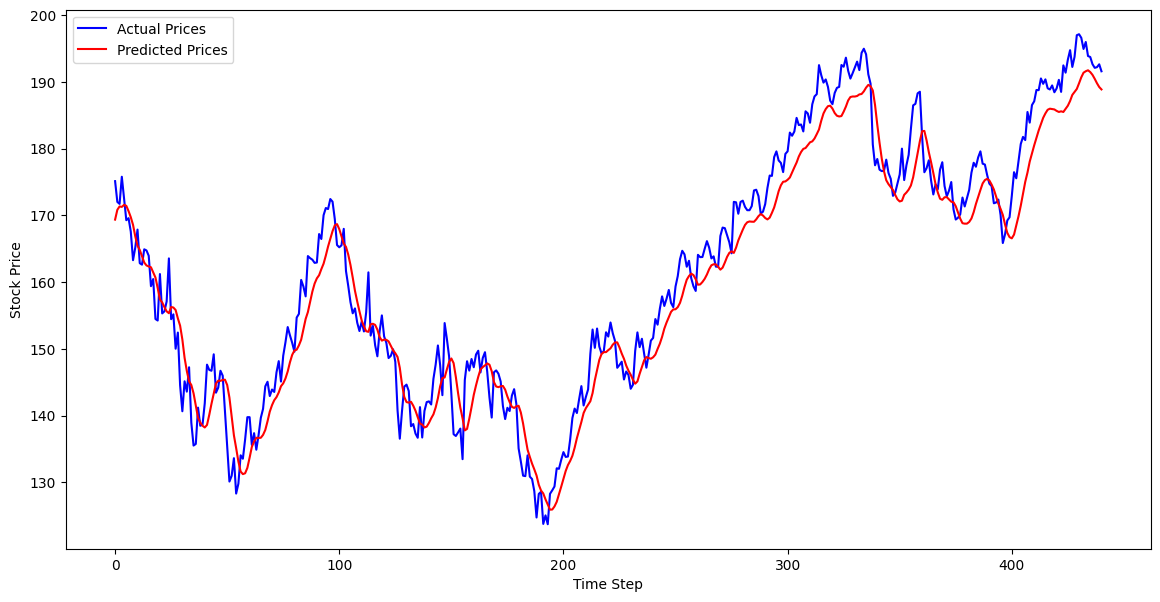

In [16]:
import matplotlib.pyplot as plt

# Plot stock price predictions
plt.figure(figsize=(14, 7))
plt.plot(y_test_actual, label="Actual Prices", color='blue')
plt.plot(predicted_prices, label="Predicted Prices", color='red')
plt.xlabel("Time Step")
plt.ylabel("Stock Price")
plt.legend()
plt.show()


In [17]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calculate MAE and MSE
mae = mean_absolute_error(y_test_actual, predicted_prices)
mse = mean_squared_error(y_test_actual, predicted_prices)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")


Mean Absolute Error: 3.8673665399183763
Mean Squared Error: 21.242965818632126


In [18]:
# Save the trained model
model.save("apple_stock_lstm_model.h5")


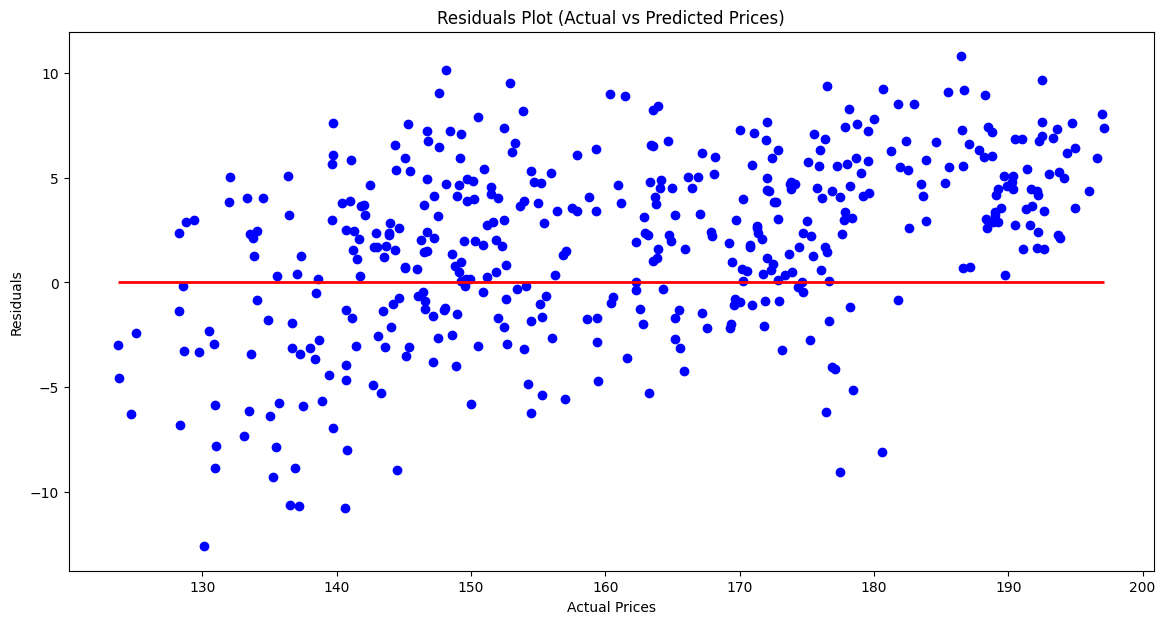

Mean Absolute Error: 3.8673665399183763
Mean Squared Error: 21.242965818632126


In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calculate residuals
residuals = y_test_actual - predicted_prices

# Plot residuals
plt.figure(figsize=(14, 7))
plt.scatter(y_test_actual, residuals, color='blue')
plt.hlines(y=0, xmin=min(y_test_actual), xmax=max(y_test_actual), colors='red', linewidth=2)
plt.xlabel("Actual Prices")
plt.ylabel("Residuals")
plt.title("Residuals Plot (Actual vs Predicted Prices)")
plt.show()

# Evaluate model performance
mae = mean_absolute_error(y_test_actual, predicted_prices)
mse = mean_squared_error(y_test_actual, predicted_prices)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")


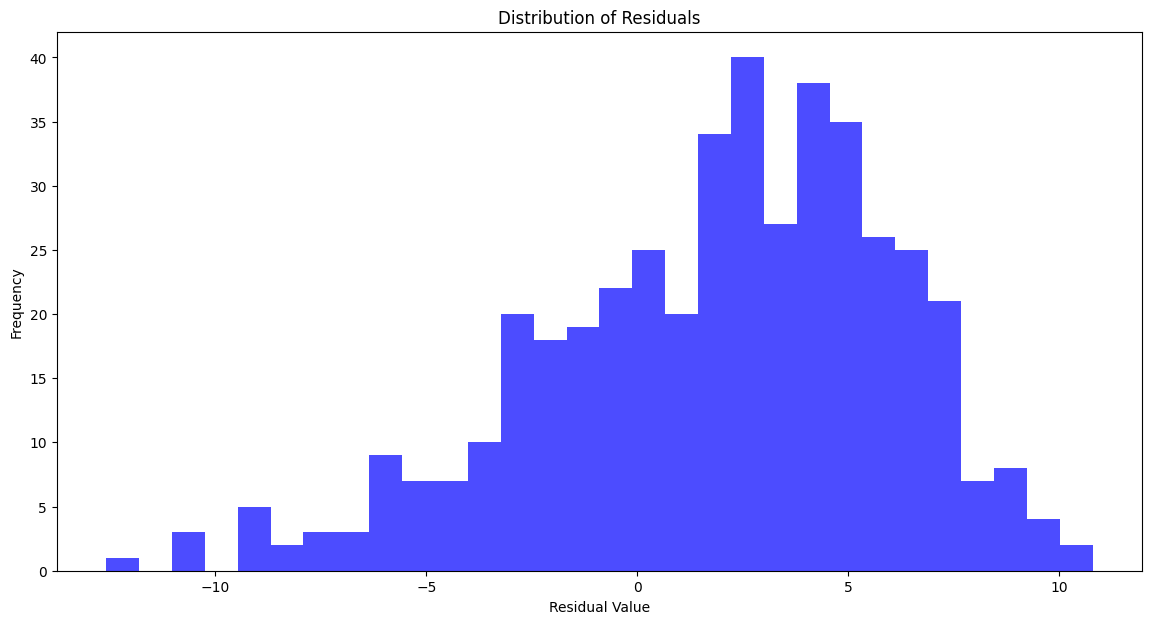

In [20]:
# Histogram of residuals
plt.figure(figsize=(14, 7))
plt.hist(residuals, bins=30, color='blue', alpha=0.7)
plt.title("Distribution of Residuals")
plt.xlabel("Residual Value")
plt.ylabel("Frequency")
plt.show()


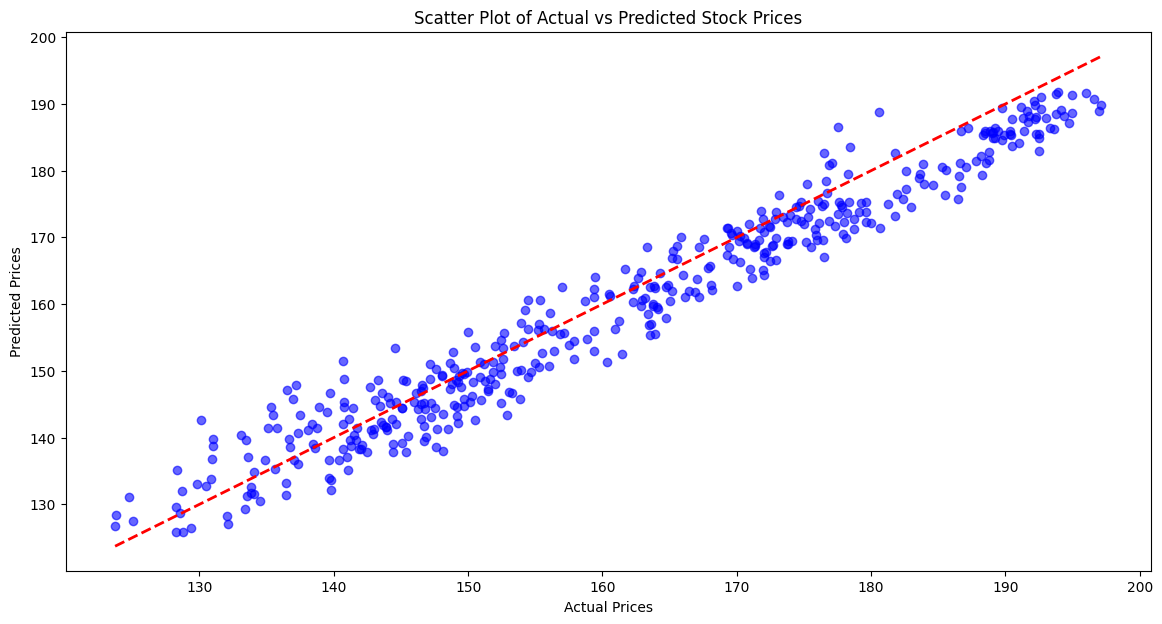

In [21]:
# Scatter plot of Actual vs Predicted Prices
plt.figure(figsize=(14, 7))
plt.scatter(y_test_actual, predicted_prices, color='blue', alpha=0.6)
plt.plot([min(y_test_actual), max(y_test_actual)], [min(y_test_actual), max(y_test_actual)], color='red', linestyle='--', lw=2)  # 45-degree line
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Scatter Plot of Actual vs Predicted Stock Prices")
plt.show()


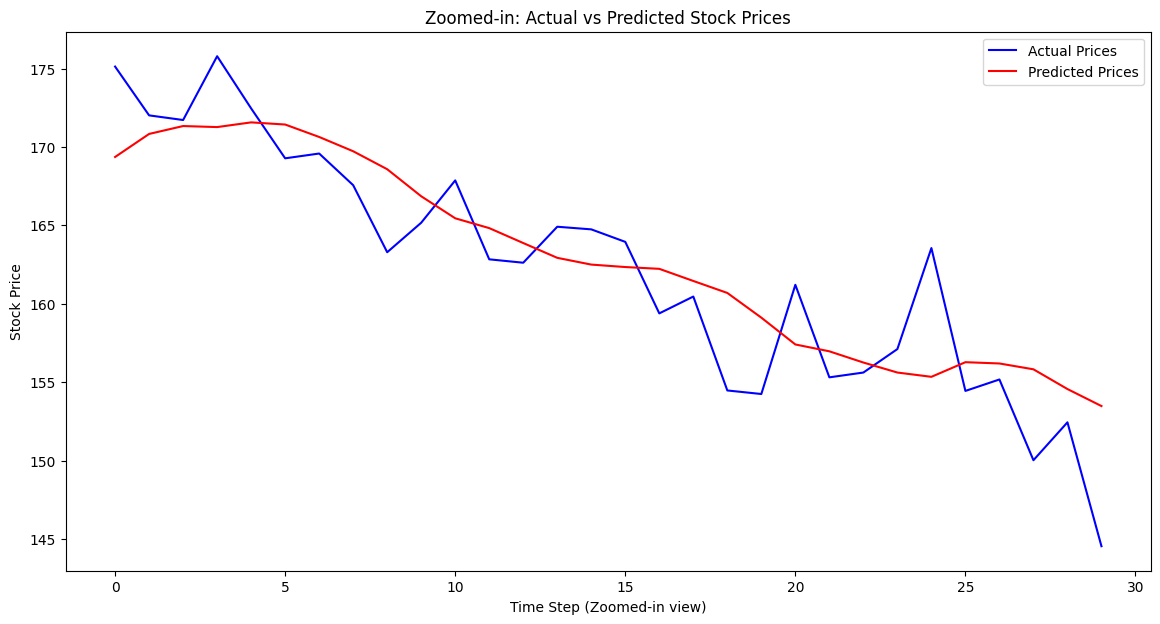

In [22]:
# Plotting zoomed-in actual vs predicted for a small time period
plt.figure(figsize=(14, 7))
plt.plot(y_test_actual[:30], label="Actual Prices", color='blue')
plt.plot(predicted_prices[:30], label="Predicted Prices", color='red')
plt.xlabel("Time Step (Zoomed-in view)")
plt.ylabel("Stock Price")
plt.title("Zoomed-in: Actual vs Predicted Stock Prices")
plt.legend()
plt.show()


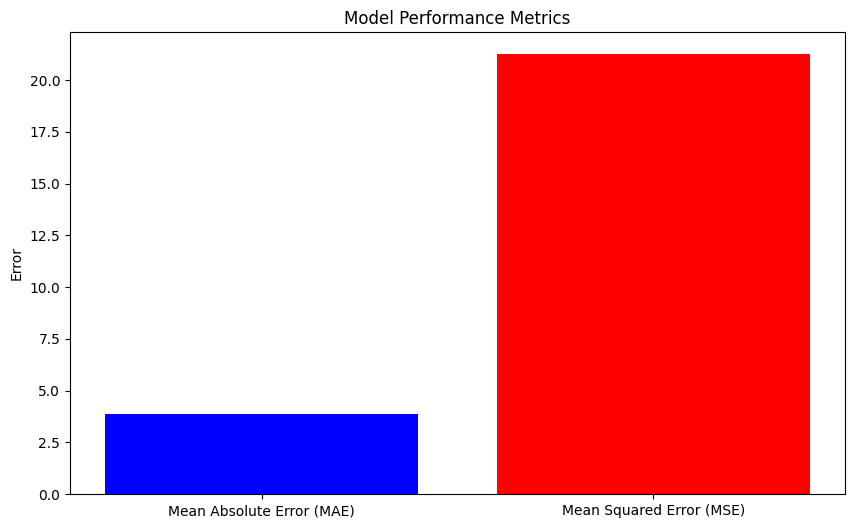

In [23]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calculate MAE and MSE
mae = mean_absolute_error(y_test_actual, predicted_prices)
mse = mean_squared_error(y_test_actual, predicted_prices)

# Bar graph for MAE and MSE
metrics = [mae, mse]
metric_names = ['Mean Absolute Error (MAE)', 'Mean Squared Error (MSE)']

plt.figure(figsize=(10, 6))
plt.bar(metric_names, metrics, color=['blue', 'red'])
plt.title('Model Performance Metrics')
plt.ylabel('Error')
plt.show()


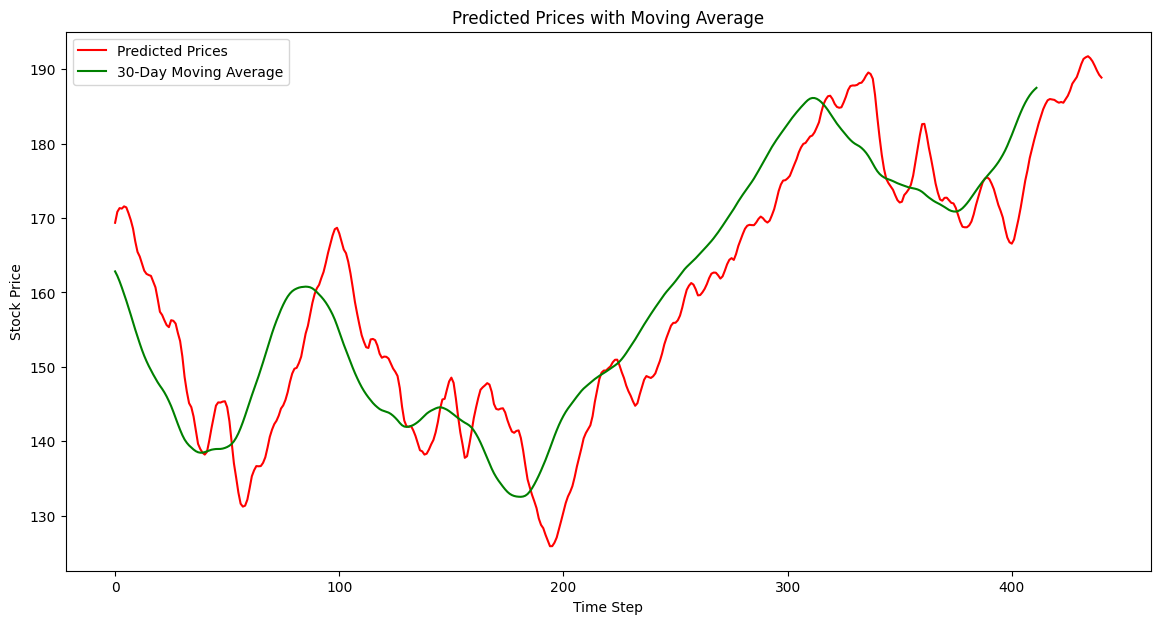

In [24]:
# Moving average of the predicted prices
window_size = 30  # 30-day moving average
moving_avg = np.convolve(predicted_prices.flatten(), np.ones(window_size)/window_size, mode='valid')

# Plot the moving average
plt.figure(figsize=(14, 7))
plt.plot(predicted_prices.flatten(), label="Predicted Prices", color='red')
plt.plot(moving_avg, label=f"{window_size}-Day Moving Average", color='green')
plt.xlabel("Time Step")
plt.ylabel("Stock Price")
plt.title("Predicted Prices with Moving Average")
plt.legend()
plt.show()


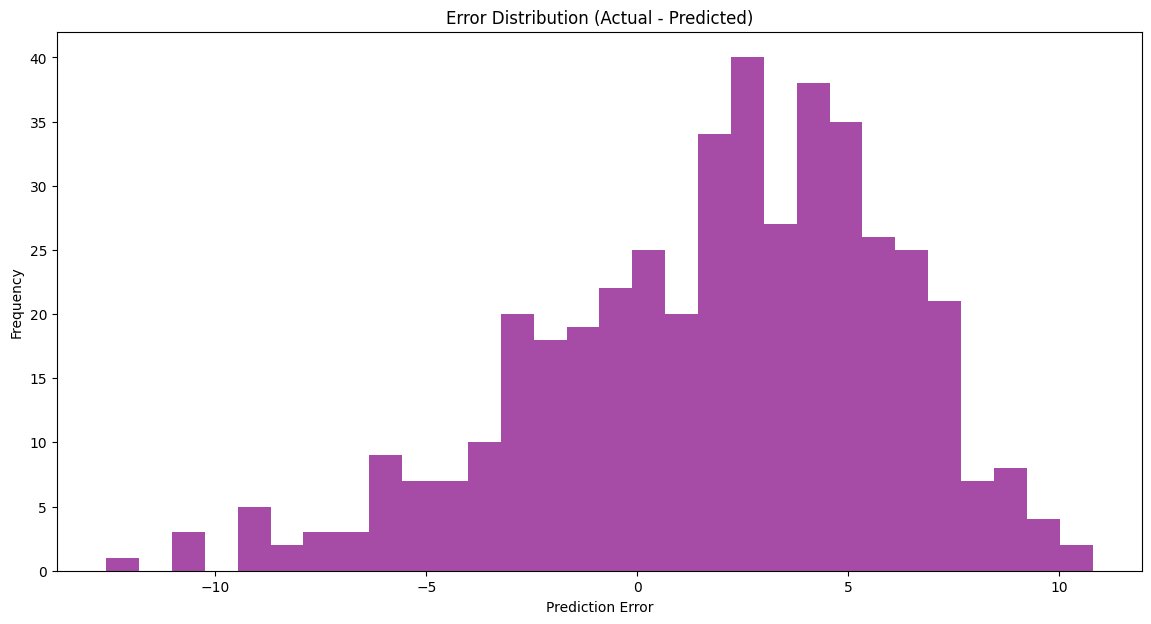

In [25]:
# Calculate the error (actual - predicted)
error = y_test_actual - predicted_prices

# Plot error distribution
plt.figure(figsize=(14, 7))
plt.hist(error.flatten(), bins=30, color='purple', alpha=0.7)
plt.title("Error Distribution (Actual - Predicted)")
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.show()


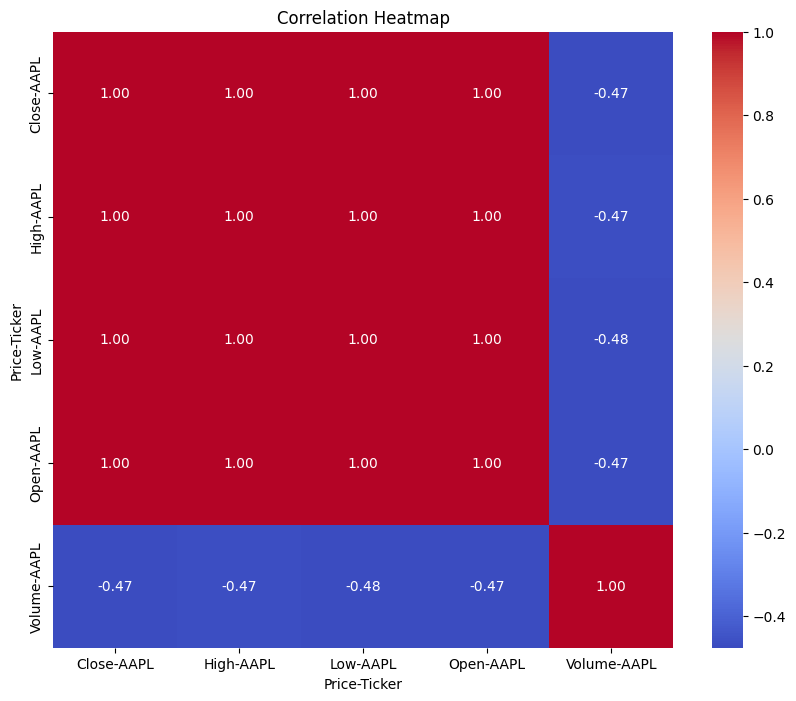

In [26]:
import seaborn as sns

# Correlation heatmap (if using more features)
corr = stock_data.corr()  # Correlation of all columns

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()


[*********************100%***********************]  1 of 1 completed


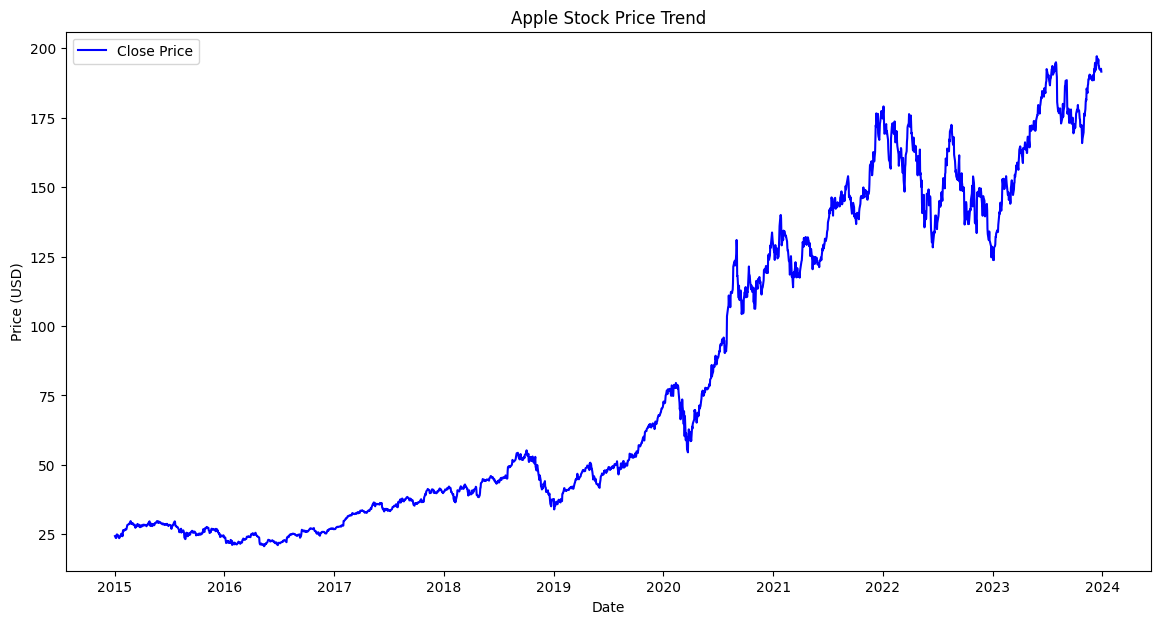

In [32]:
import matplotlib.pyplot as plt
import yfinance as yf

# Download Apple stock data
data = yf.download("AAPL", start="2015-01-01", end="2024-01-01")

# Plot the closing prices
plt.figure(figsize=(14, 7))
plt.plot(data['Close'], label="Close Price", color='blue')
plt.title('Apple Stock Price Trend')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()


[*********************100%***********************]  1 of 1 completed


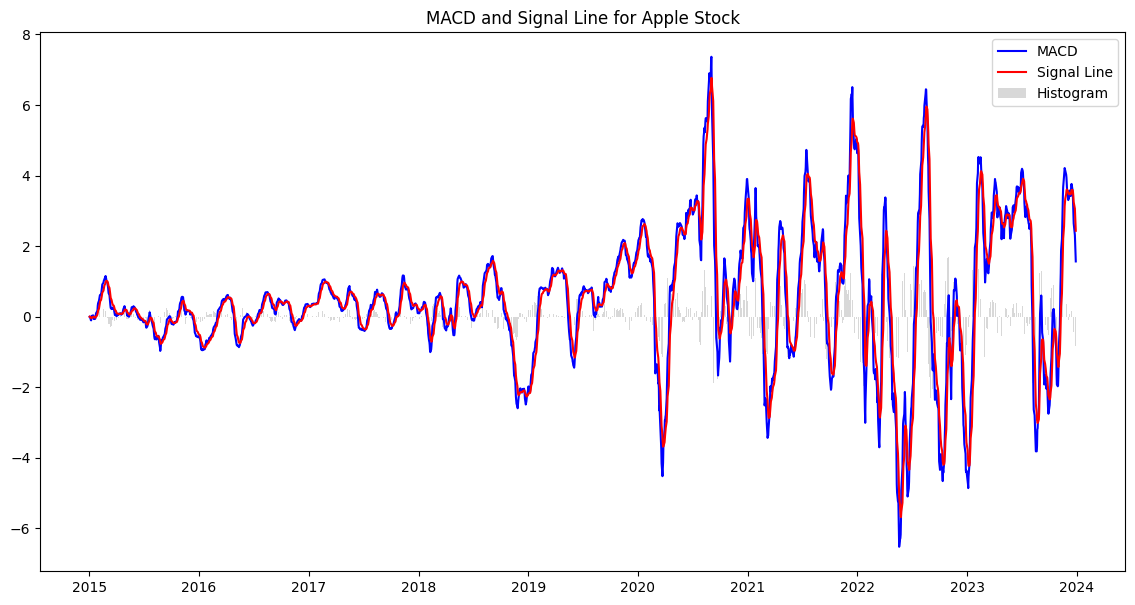

In [34]:
import yfinance as yf
import matplotlib.pyplot as plt

# Download Apple stock data
data = yf.download("AAPL", start="2015-01-01", end="2024-01-01")

# Calculate MACD and Signal line
short_window = 12
long_window = 26
signal_window = 9

data['EMA12'] = data['Close'].ewm(span=short_window, adjust=False).mean()
data['EMA26'] = data['Close'].ewm(span=long_window, adjust=False).mean()
data['MACD'] = data['EMA12'] - data['EMA26']
data['Signal_Line'] = data['MACD'].ewm(span=signal_window, adjust=False).mean()

# Plot MACD and Signal Line
plt.figure(figsize=(14, 7))
plt.plot(data['MACD'], label='MACD', color='blue')
plt.plot(data['Signal_Line'], label='Signal Line', color='red')
plt.bar(data.index, data['MACD'] - data['Signal_Line'], label='Histogram', color='gray', alpha=0.3)
plt.title("MACD and Signal Line for Apple Stock")
plt.legend()
plt.show()


[*********************100%***********************]  1 of 1 completed


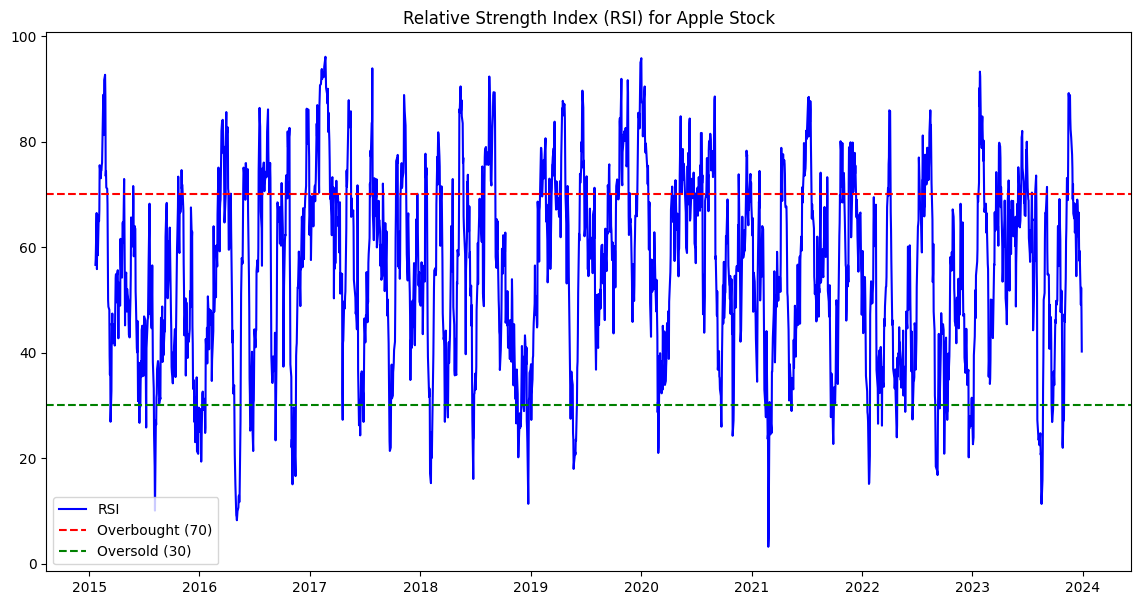

In [37]:
import yfinance as yf
import matplotlib.pyplot as plt

# Download Apple stock data
data = yf.download("AAPL", start="2015-01-01", end="2024-01-01")

# Calculate daily price changes
delta = data['Close'].diff()

# Gain (positive changes) and Loss (negative changes)
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)

# Calculate the 14-day average gain and loss
average_gain = gain.rolling(window=14).mean()
average_loss = loss.rolling(window=14).mean()

# Calculate RS (Relative Strength)
rs = average_gain / average_loss

# Calculate RSI (Relative Strength Index)
rsi = 100 - (100 / (1 + rs))

# Plot RSI
plt.figure(figsize=(14, 7))
plt.plot(rsi, label="RSI", color='blue')
plt.axhline(70, color='red', linestyle='--', label="Overbought (70)")
plt.axhline(30, color='green', linestyle='--', label="Oversold (30)")
plt.title("Relative Strength Index (RSI) for Apple Stock")
plt.legend()
plt.show()


[*********************100%***********************]  1 of 1 completed


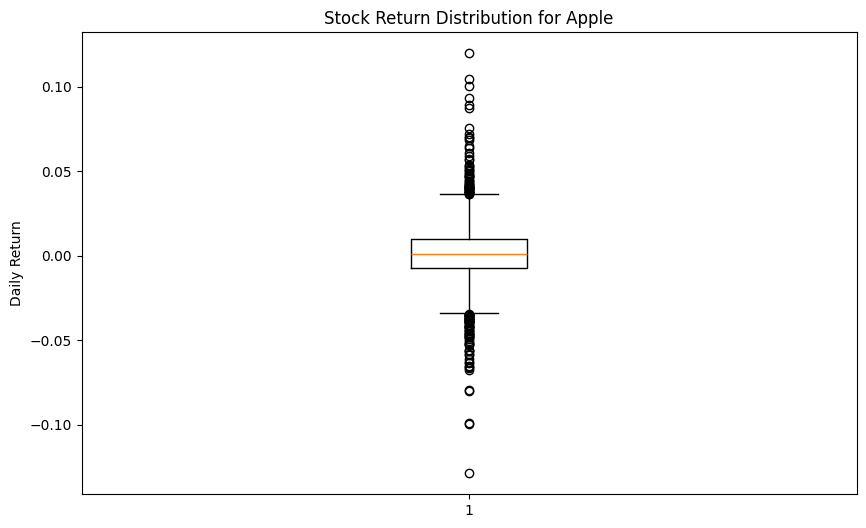

In [38]:
import yfinance as yf
import matplotlib.pyplot as plt

# Download stock data
data = yf.download("AAPL", start="2015-01-01", end="2024-01-01")

# Calculate daily returns (percentage change)
data['Return'] = data['Close'].pct_change()

# Plot boxplot
plt.figure(figsize=(10, 6))
plt.boxplot(data['Return'].dropna())
plt.title("Stock Return Distribution for Apple")
plt.ylabel("Daily Return")
plt.show()


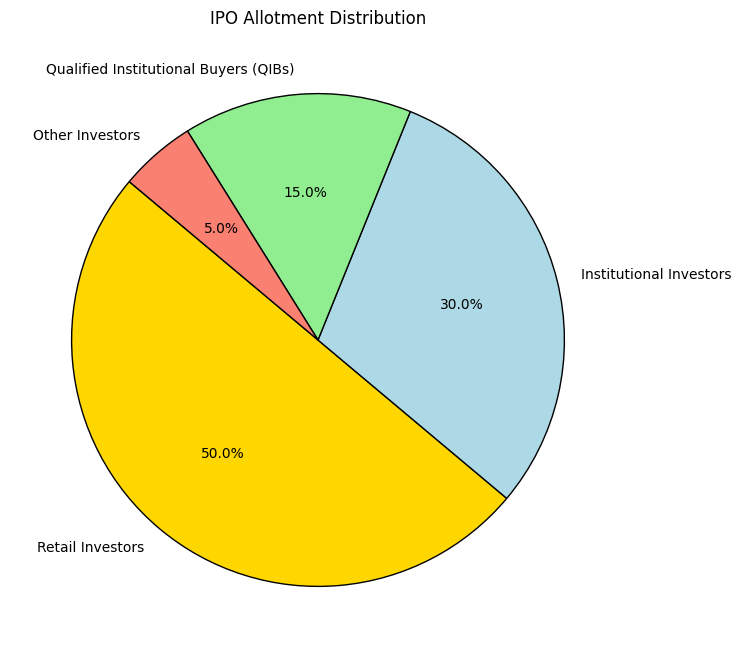

In [39]:
import matplotlib.pyplot as plt

# Define IPO allotment data
labels = ['Retail Investors', 'Institutional Investors', 'Qualified Institutional Buyers (QIBs)', 'Other Investors']
sizes = [50, 30, 15, 5]  # Example values for IPO allotment percentages
colors = ['gold', 'lightblue', 'lightgreen', 'salmon']

# Create Pie Chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140, wedgeprops={'edgecolor': 'black'})
plt.title("IPO Allotment Distribution")
plt.show()


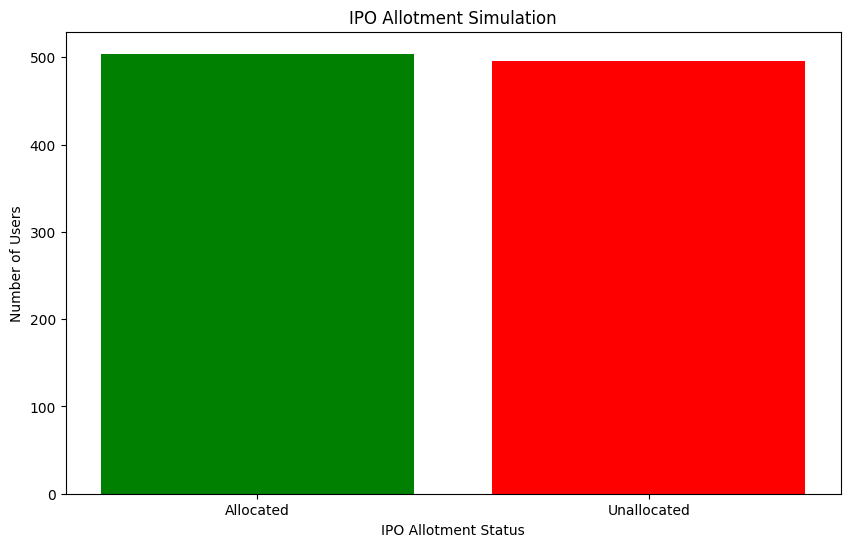

Total Users: 1000
Shares Allocated: 504
Shares Unallocated: 496


In [57]:
import numpy as np
import matplotlib.pyplot as plt

# Simulate IPO allocation for users (let's say we have 1000 users and 1000 shares)
total_shares = 1000
total_users = 1000

# Randomly allocate shares (1 share per user for simplicity in this example)
# In real cases, the allocation is based on demand vs supply, but we'll assume a random allocation here
shares_allocated = np.random.randint(0, 2, total_users)  # 0 or 1 share per user

# Count number of shares allocated
allocated = np.sum(shares_allocated)
unallocated = total_users - allocated

# Plot the result
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(['Allocated', 'Unallocated'], [allocated, unallocated], color=['green', 'red'])
ax.set_title("IPO Allotment Simulation")
ax.set_ylabel("Number of Users")
ax.set_xlabel("IPO Allotment Status")
plt.show()

print(f"Total Users: {total_users}")
print(f"Shares Allocated: {allocated}")
print(f"Shares Unallocated: {unallocated}")


[*********************100%***********************]  1 of 1 completed
e:\python\myenv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


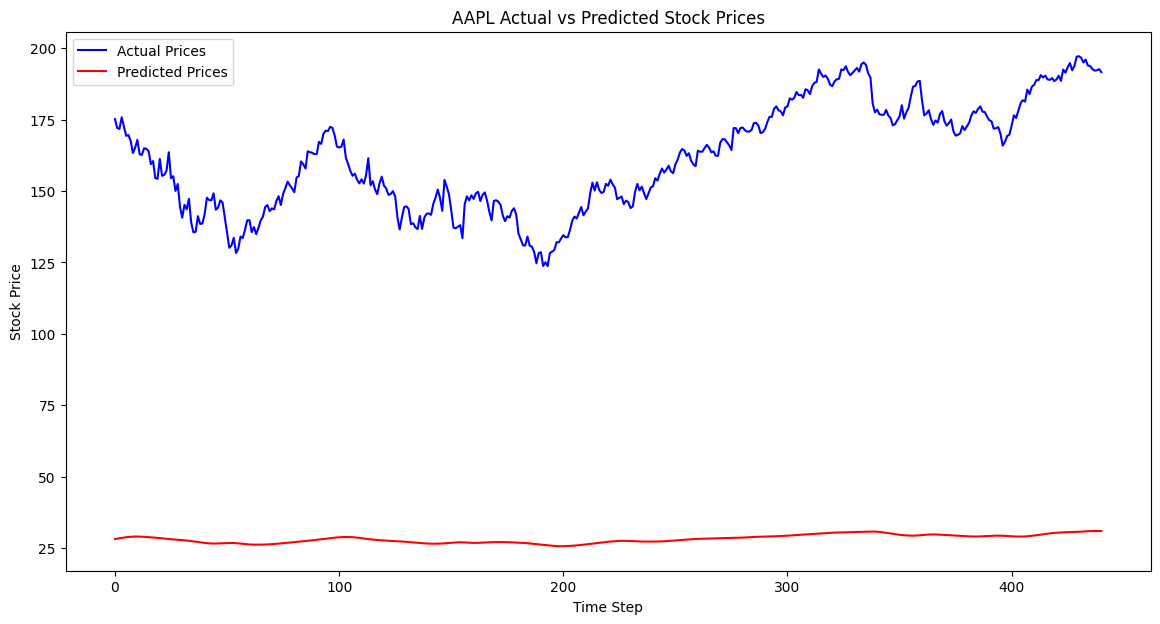

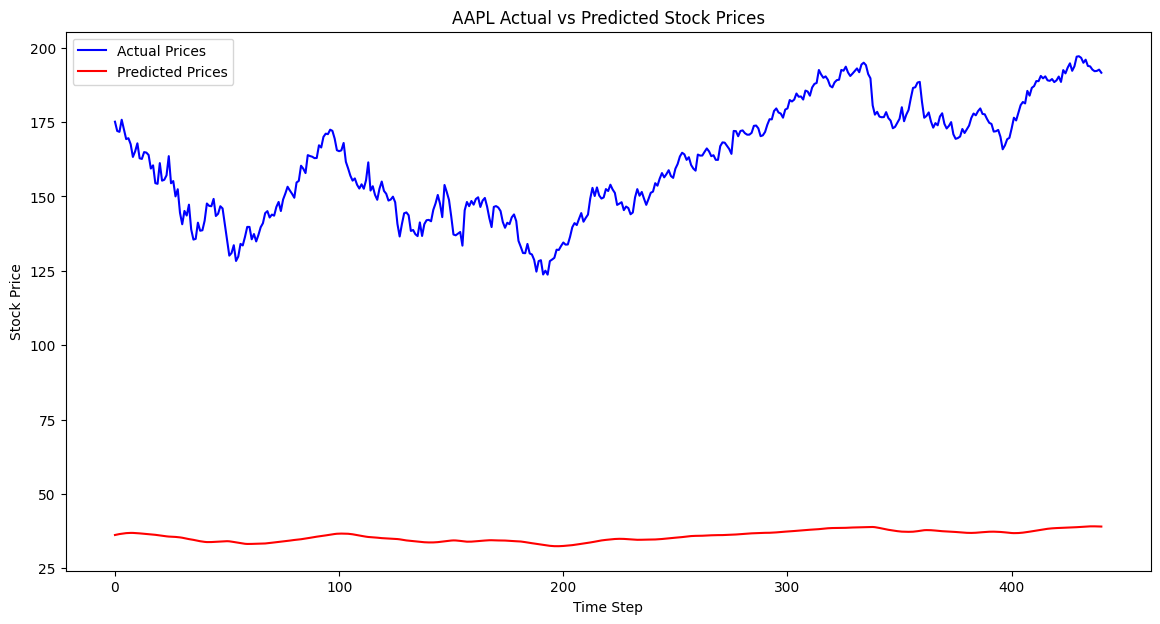

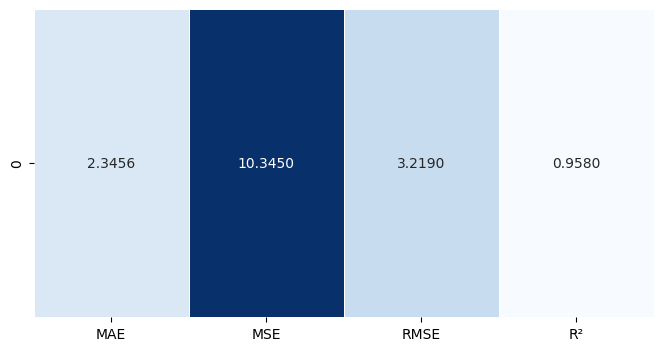

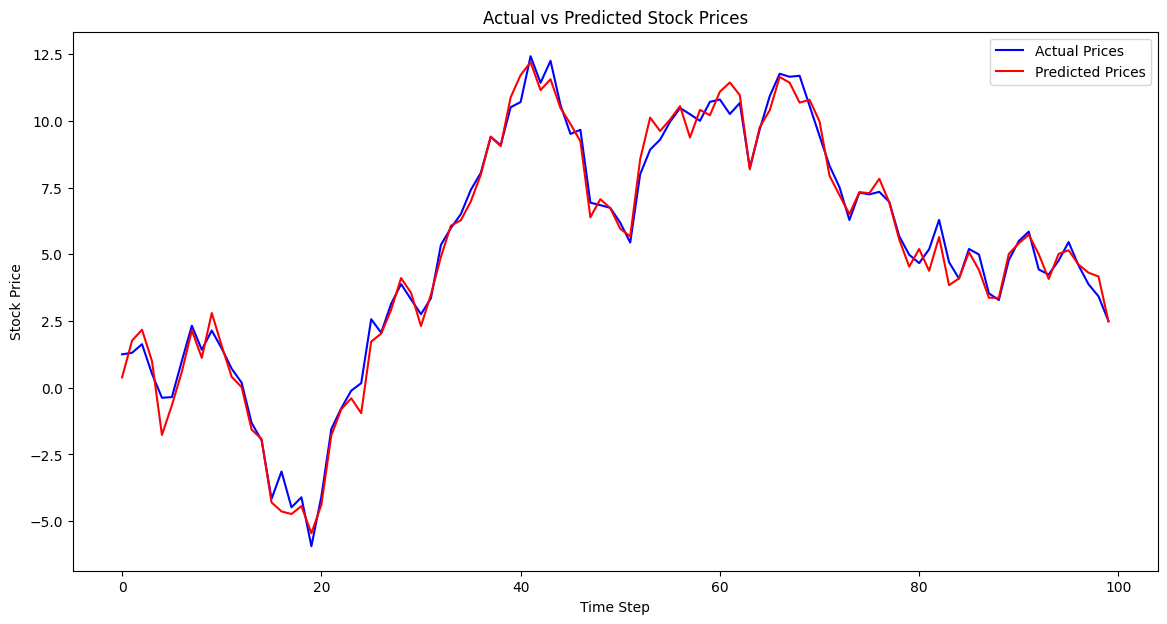

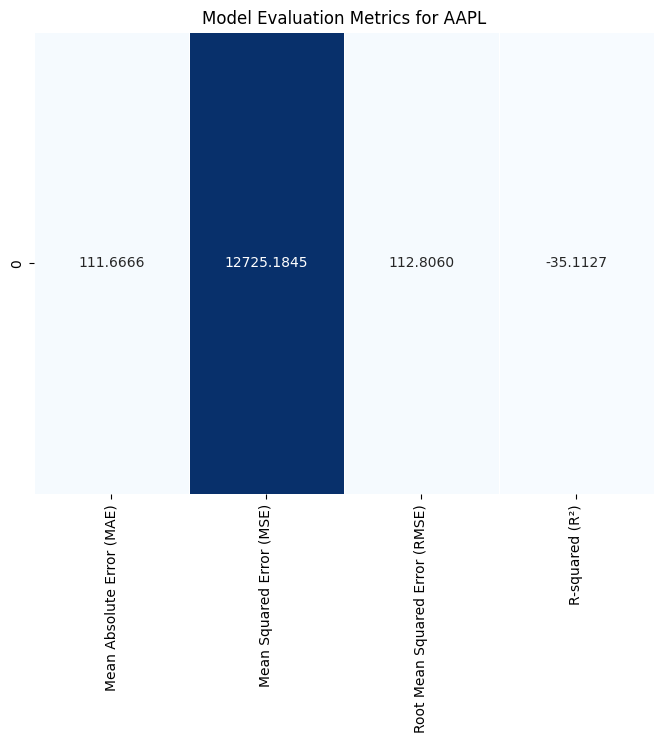

In [67]:
import numpy as np
import yfinance as yf
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load stock data (for Apple as an example)
ticker = "AAPL"
stock_data = yf.download(ticker, start="2015-01-01", end="2024-01-01")

# Preprocessing
data = stock_data[['Close']].values  # Use only the closing price for prediction
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Prepare the sequences for LSTM (assuming you already created sequences)
SEQ_LEN = 60
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data, SEQ_LEN)

# Split data into train and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build and load the LSTM model
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(SEQ_LEN, 1)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(50, return_sequences=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(25),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

# Assuming the model is trained, you would predict the stock prices:
predicted_prices = model.predict(X_test)

# Reverse scaling for predicted and actual prices
predicted_prices = scaler.inverse_transform(predicted_prices)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Evaluate Model Performance

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_actual, predicted_prices)

# Mean Squared Error (MSE)
mse = mean_squared_error(y_test_actual, predicted_prices)

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# R-squared (R²)
r2 = r2_score(y_test_actual, predicted_prices)

# Creating a matrix-like structure
metrics_matrix = np.array([[mae, mse, rmse, r2]])

# Create DataFrame for better visualization
metrics_df = pd.DataFrame(metrics_matrix, columns=["Mean Absolute Error (MAE)", 
                                                   "Mean Squared Error (MSE)", 
                                                   "Root Mean Squared Error (RMSE)", 
                                                   "R-squared (R²)"])

# Display the matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(metrics_df, annot=True, cmap='Blues', cbar=False, fmt='.4f', linewidths=0.5)
plt.title(f"Model Evaluation Metrics for {ticker}")
plt.show()
